# Faraday - Streaming Training Data

This tutorial explains how to use Faraday to train a generative model from a streaming dataset.
This is important if the source data is too large to fit in device memory.

---

For more information on Faraday's architecture, refer to the [Faraday paper](https://arxiv.org/abs/2404.04314).

For more information on litdata (torch streaming library), refer to the [litdata docs](https://github.com/Lightning-AI/litdata)


### Pre-requisites

1. If you haven't already, please download LCL dataset from [data.london.gov.uk](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households), or...
2. Use the cli app to download and prepare the data (see README)
3. Follow the tutorial 'faraday_tutorial.ipynb' to train Faraday using the traditional method

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging

logger = logging.getLogger(__name__)

# 💿 Loading Data Modules

In [3]:
from pathlib import Path
from opensynth.data_modules.streaming_data_module import StreamDataModule

stream_data_path = Path("../../data/processed/historical/stream")
stats_path = Path("../../data/processed/historical/train/mean_std.csv")

dm = StreamDataModule(
    data_path=str(stream_data_path),
    stats_path=stats_path,
    num_workers=9,
    batch_size=500,
    max_cache_size="10GB",
    shuffle=False,
    persistent_workers=True,
)
dm.setup()

# 🤖 VAE Module

In [4]:
from opensynth.models.faraday.model import FaradayVAE
# Option to pass in your own encoder architecture in the future
model = FaradayVAE(
    class_dim=2,
    latent_dim=16,
    learning_rate=0.001,
    mse_weight=3,
)

In [5]:
import pytorch_lightning as pl
import torch

# Batch size 500 is when MPS becomes faster than CPU..
# But sometimes large batch size hurts convergence..
# Suggest training on CPU with small batch size
# And potentially experiment with best hyperparameters on large batch size before using 'mps'

trainer = pl.Trainer(max_epochs=5, accelerator="auto")
trainer.fit(model, dm)

# Save model
torch.save(model, 'faraday_vae.pt')

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/gus.chadney/.virtualenvs/OpenSynth-n2CNCCrk/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name           | Type                    | Params | Mode 
-------------------------------------------------------------------
0 | encoder        | Encoder                 | 201 K  | train
1 | decoder        | Decoder                 | 200 K  | train
2 | reparametriser | ReparametrisationModule | 544    | train
----

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


# 🕸️ GMM Module

In [6]:
from opensynth.models.faraday.model import FaradayModel
import torch

In [ ]:
# Replace with the path to the relevant checkpoint
model = torch.load('faraday_vae.pt')

faraday_model_50 = FaradayModel(vae_module=model, n_components=50, max_iter=100, tol=1e-2)
faraday_model_10 = FaradayModel(vae_module=model, n_components=10, max_iter=100, tol=1e-2)
faraday_model_1 = FaradayModel(vae_module=model, n_components=1, max_iter=100, tol=1e-2)


/var/folders/9b/g5r5shyx32ldxjsqwhkgnt300000gn/T/ipykernel_43447/1498632332.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('faraday_vae.pt')


In [12]:
gmm_data_module = StreamDataModule(
    data_path=str(stream_data_path),
    stats_path=stats_path,
    num_workers=9,
    batch_size=5000,
    max_cache_size="10GB",
    shuffle=False,
    persistent_workers=True,
)
gmm_data_module.setup()

In [17]:
faraday_model_50.train_gmm(dm=gmm_data_module)

0it [00:00, ?it/s]/Users/gus.chadney/.virtualenvs/OpenSynth-n2CNCCrk/lib/python3.11/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
1it [00:38, 38.57s/it]/Users/gus.chadney/.virtualenvs/OpenSynth-n2CNCCrk/lib/python3.11/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
2it [00:40, 17.22s/it]/Users/gus.chadney/.virtualenvs/OpenSynth-n2CNCCrk/lib/python3.11/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
225it [05:22,  1.43s/it]


In [16]:
faraday_model_10.train_gmm(dm=gmm_data_module)

225it [03:02,  1.23it/s]


In [15]:
faraday_model_1.train_gmm(dm=gmm_data_module)

225it [01:39,  2.25it/s]


In [ ]:
torch.save(faraday_model_50, "faraday_model_50.pt")
torch.save(faraday_model_10, "faraday_model_10.pt")
torch.save(faraday_model_1, "faraday_model_1.pt")

# 📈 Comparing Results

### 0. Generating Samples

In [29]:
def generate_synthetic_samples(model, n_samples, dm):
    gmm_samples = model.sample_gmm(n_samples)
    kwh = gmm_samples['kwh']
    mth = gmm_samples['features']['month']
    dow = gmm_samples['features']['dayofweek']
    gmm_samples = dm.reconstruct_kwh(kwh)
    gmm_samples = torch.clip(gmm_samples, min=0)
    return gmm_samples

In [30]:
# gmm_1500 = generate_synthetic_samples(faraday_model_1500, 20000, dm)
# gmm_150 = generate_synthetic_samples(faraday_model_150, 20000, dm)
gmm_50 = generate_synthetic_samples(faraday_model_50, 20000, dm)
gmm_10 = generate_synthetic_samples(faraday_model_10, 20000, dm)
gmm_1 = generate_synthetic_samples(faraday_model_1, 20000, dm)

In [32]:

real_kwh = dm.reconstruct_kwh(next(iter(gmm_data_module.train_dataloader()))["kwh"])
real_kwh = torch.clip(real_kwh, min=0) # Clip min 0 to get read of negative values

### 1. Comparing mean, 95th quantile, median profiles

In [36]:
import matplotlib.pyplot as plt

def plot_stats(real_kwh, gmm_reconstruct):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 3), sharey=True, gridspec_kw={'wspace': 0.05})

    ax1.plot(real_kwh.mean(dim=0).detach().numpy(), label="real kwh")
    ax1.plot(gmm_reconstruct.mean(dim=0).detach().numpy(), label="gmm kwh")
    ax1.set_title("Mean kWh per half hour")
    ax1.set_xlabel("Settlement Periods")
    ax1.legend()

    ax2.plot(real_kwh.quantile(0.95, dim=0).detach().numpy(), label="real kwh")
    ax2.plot(gmm_reconstruct.quantile(0.95, dim=0).detach().numpy(), label="gmm kwh")
    ax2.set_title("95th Quantile kWh per half hour")
    ax2.set_xlabel("Settlement Periods")
    ax2.legend()

    ax3.plot(real_kwh.quantile(0.5, dim=0).detach().numpy(), label="real kwh")
    ax3.set_title("Median kWh per half hour")
    ax3.set_xlabel("Settlement Periods")
    ax3.plot(gmm_reconstruct.quantile(0.5, dim=0).detach().numpy(), label="gmm kwh")
    ax3.legend()

    fig.text(0.1, 0.5, 'kWh', va='center', rotation='vertical')

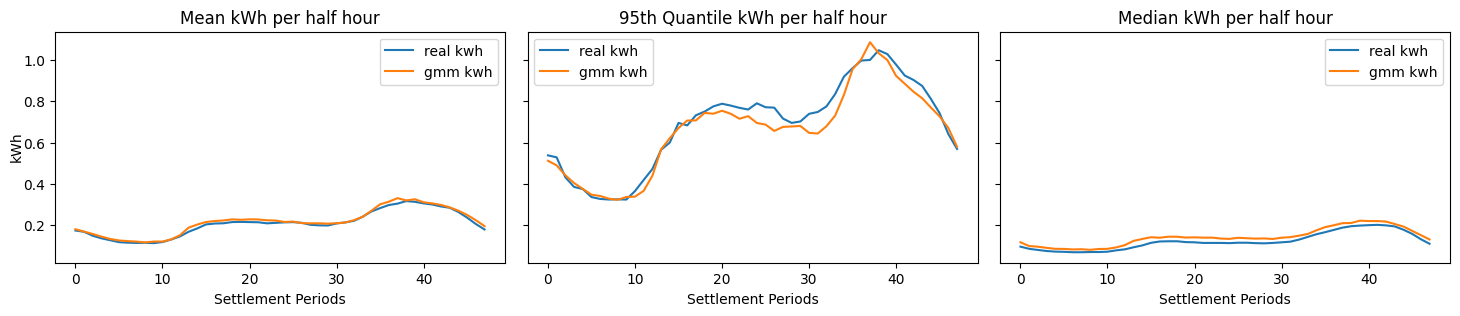

In [37]:
plot_stats(real_kwh, gmm_50)

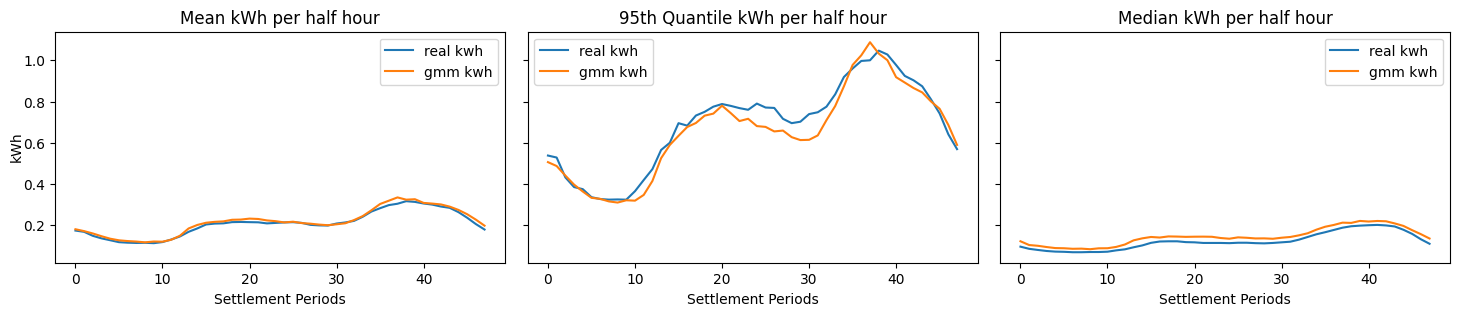

In [38]:
plot_stats(real_kwh, gmm_10)

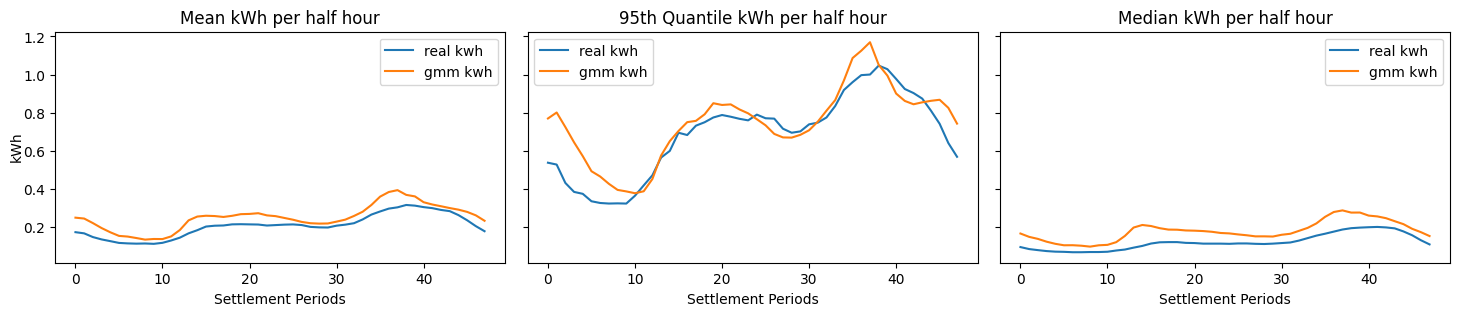

In [39]:
plot_stats(real_kwh, gmm_1)

### 2. PCA and TSNE Distribution Plots

In [41]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np


def train_pca_and_tsne(real_kwh, gmm_reconstruct):
    pca = PCA(n_components=2)
    tsne = TSNE(n_components=2)

    pca.fit(real_kwh.detach().numpy())
    pca_real = pca.transform(real_kwh.detach().numpy())
    pca_gmm = pca.transform(gmm_reconstruct.detach().numpy())

    tsne_input = np.concatenate([real_kwh.detach().numpy(), gmm_reconstruct.detach().numpy()])
    tsne_results = tsne.fit_transform(tsne_input)
    tsne_real = tsne_results[:len(real_kwh)]
    tsne_gmm = tsne_results[len(real_kwh):]

    return pca_real, pca_gmm, tsne_real, tsne_gmm


def plot_pca_tsne(pca_real, pca_gmm, tsne_real, tsne_gmm):
    fig, (ax_pca, ax_tsne) = plt.subplots(1, 2, figsize=(12, 4))

    ax_pca.scatter(pca_real[:, 0], pca_real[:, 1], label="real kwh", s=0.3, alpha=0.5)
    ax_pca.scatter(pca_gmm[:, 0], pca_gmm[:, 1], label="gmm kwh", s=0.3, alpha=0.5)
    ax_pca.set_title("PCA")
    ax_pca.set_xlabel("PCA 1")
    ax_pca.set_ylabel("PCA 2")
    ax_pca.legend()

    ax_tsne.scatter(tsne_real[:, 0], tsne_real[:, 1], label="real kwh", s=0.3, alpha=0.5)
    ax_tsne.scatter(tsne_gmm[:, 0], tsne_gmm[:, 1], label="gmm kwh", s=0.3, alpha=0.5)
    ax_tsne.set_title("TSNE")
    ax_tsne.set_xlabel("TSNE 1")
    ax_tsne.set_ylabel("TSNE 2")
    ax_tsne.legend()
    return fig


Text(0.5, 1.0, 'GMM with 50 clusters')

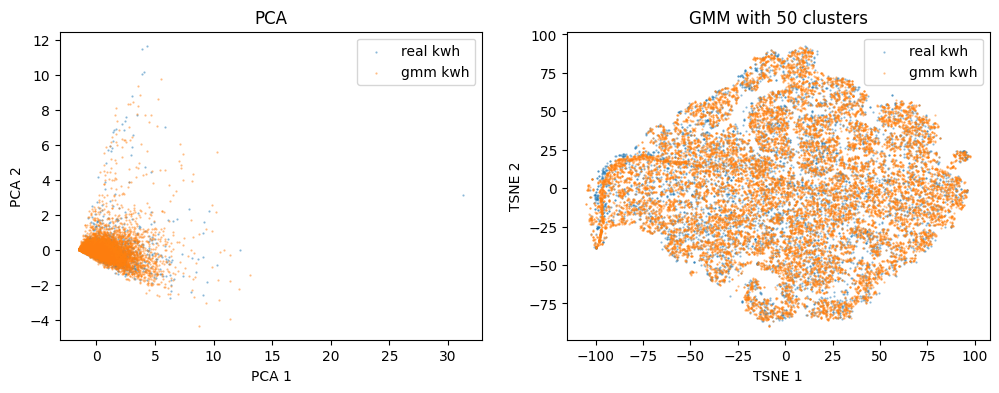

In [44]:
c1, c2, c3, c4 = train_pca_and_tsne(real_kwh, gmm_50)
_ = plot_pca_tsne(c1, c2, c3, c4)
plt.title("GMM with 50 clusters")

Text(0.5, 1.0, 'GMM with 10 clusters')

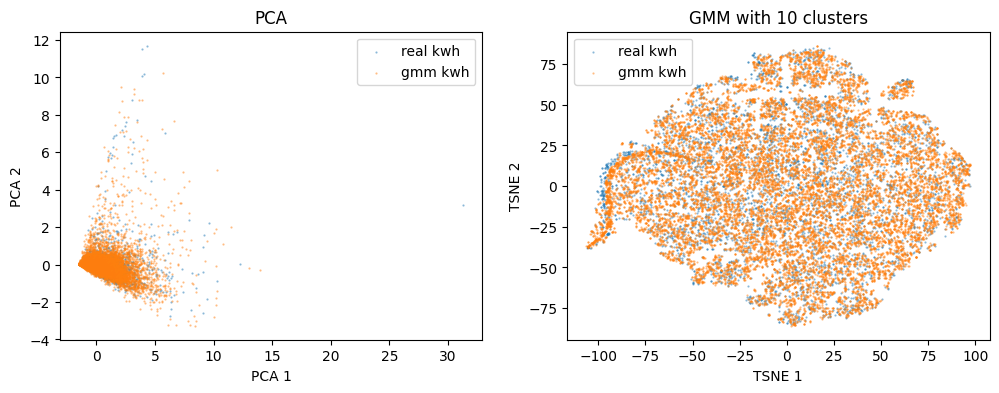

In [45]:
d1, d2, d3, d4 = train_pca_and_tsne(real_kwh, gmm_10)
_ = plot_pca_tsne(d1, d2, d3, d4)
plt.title("GMM with 10 clusters")

Text(0.5, 1.0, 'GMM with 10 clusters')

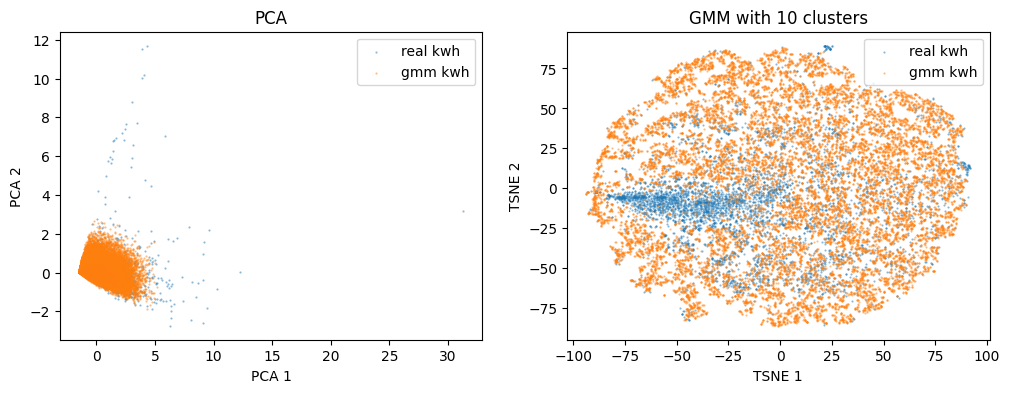

In [46]:
e1, e2, e3, e4 = train_pca_and_tsne(real_kwh, gmm_1)
_ = plot_pca_tsne(e1, e2, e3, e4)
plt.title("GMM with 10 clusters")